In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Peterlin function
def peterlin(sigma, L2=50.0):
    tr_sigma = np.trace(sigma)
    return (L2 - 3.0) / (L2 - tr_sigma)

# Upper-convected derivative
# ∇σ = dσ/dt - (σ·∇v + (∇v)^T·σ)
def upper_convected(t, sigma, grad):
    return - (sigma @ grad + grad.T @ sigma)

# System of ODEs for sigma_u and sigma_b (both 3x3 -> flattened 18 variables)
def rhs(t, y):
    sigma_u = y[:9].reshape((3, 3))
    sigma_b = y[9:].reshape((3, 3))
    grad = grad_v(t)

    # Compute Peterlin factors
    # fP_u = peterlin(sigma_u)
    # fP_b = peterlin(sigma_b)
    fP_u = 1
    fP_b = 1

    # Eqn for sigma_u
    dsigma_u_dt = n * kB * T * ( grad + grad.T ) \
                   - ((1 + k_plus * tau_u) * fP_u * sigma_u \
                   + k_minus * tau_u * fP_b * sigma_b \
                   - tau_u * upper_convected(t, sigma_u, grad))/tau_u

    dsigma_b_dt = n * kB * T * ( grad + grad.T ) \
                   - ((1 + k_minus * tau_b) * fP_b * sigma_b \
                   + k_plus * tau_b * fP_u * sigma_u \
                   - tau_b * upper_convected(t, sigma_b, grad))/tau_b

    return np.concatenate([dsigma_u_dt.flatten(), dsigma_b_dt.flatten()])

# Code loop to compute multiple strain-rate values

In [3]:
# Define parameters
kB = 1.0
T = 1.0
tau_u = 1.0
tau_b = 1.0
k_plus = 0
k_minus = 0
n = 1

StrainRate=[0.001, 0.01, 0.1, 1.0, 2.0, 3.0]

# Velocity gradient tensor (example: simple shear)
def grad_v(t):
    return 0.5*np.array([[2*StrainRate[i], 0.0, 0.0],
                         [0.0, -StrainRate[i], 0.0],
                         [0.0, 0.0, -StrainRate[i]]])

# Initial conditions (identity tensors)
sigma_u0 = np.eye(3)
sigma_b0 = np.eye(3)
y0 = np.concatenate([sigma_u0.flatten(), sigma_b0.flatten()])


# Time span
t_span = (0, 100)
t_eval = np.linspace(t_span[0], t_span[1], 5000000)

#Lists to hold outputted data
sigma_u_list = []
sigma_b_list = []
time_list = []

for i in range(len(StrainRate)):
    # Solve
    sol = solve_ivp(rhs, t_span, y0, t_eval=t_eval, method='RK45')

    #----------------------------------------
    #Code below to extract only a set amount of solutions to make the graphs generate faster!
    # Extract solutions
    # Number of samples you want
    n_samples = 200  # for example

    # Get time array from the solution
    t = sol.t
    y=sol.y
    mask = t > 0
    t = t[mask]
    y = y[:, mask]

    # Create log-spaced sampling points between min and max of t
    t_log = np.logspace(np.log10(t[0]), np.log10(t[-1]), n_samples)

    # Interpolate solution at those points
    from scipy.interpolate import interp1d

    interp_func = interp1d(t, y, kind='linear', axis=1, fill_value="extrapolate")
    y_log = interp_func(t_log)

    # Recreate the sigma_u and sigma_b arrays
    sigma_u_sol = y_log[:9, :].T.reshape(-1, 3, 3)
    sigma_b_sol = y_log[9:, :].T.reshape(-1, 3, 3)
    #Append to lists to keep outside the loop
    sigma_u_list.append(sigma_u_sol)
    sigma_b_list.append(sigma_b_sol)
    #----------------------------------------
    #sigma_u_sol = sol.y[:9, :].T.reshape(-1, 3, 3)
    #sigma_b_sol = sol.y[9:, :].T.reshape(-1, 3, 3)

    # Example: print sigma_u at final time
    print(f"Sigma_u at t=10 for strain_rate={StrainRate[i]}:")
    print(sigma_u_sol[-1])

    # ---- Plotting ----
    t = sol.t
    t=t_log
    time_list.append(t)

Sigma_u at t=10 for strain_rate=0.001:
[[ 0.00199646  0.          0.        ]
 [ 0.         -0.00100071  0.        ]
 [ 0.          0.         -0.00100071]]
Sigma_u at t=10 for strain_rate=0.01:
[[ 0.01962761  0.          0.        ]
 [ 0.         -0.01010079  0.        ]
 [ 0.          0.         -0.01010079]]
Sigma_u at t=10 for strain_rate=0.1:
[[ 0.1670456   0.          0.        ]
 [ 0.         -0.11111111  0.        ]
 [ 0.          0.         -0.11111111]]
Sigma_u at t=10 for strain_rate=1.0:
[[  0.66728787   0.           0.        ]
 [  0.         -99.           0.        ]
 [  0.           0.         -99.        ]]
Sigma_u at t=10 for strain_rate=2.0:
[[ 8.00991064e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.69050775e+43  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.69050775e+43]]
Sigma_u at t=10 for strain_rate=3.0:
[[ 8.57385206e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -3.62619366e+86  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -3.6

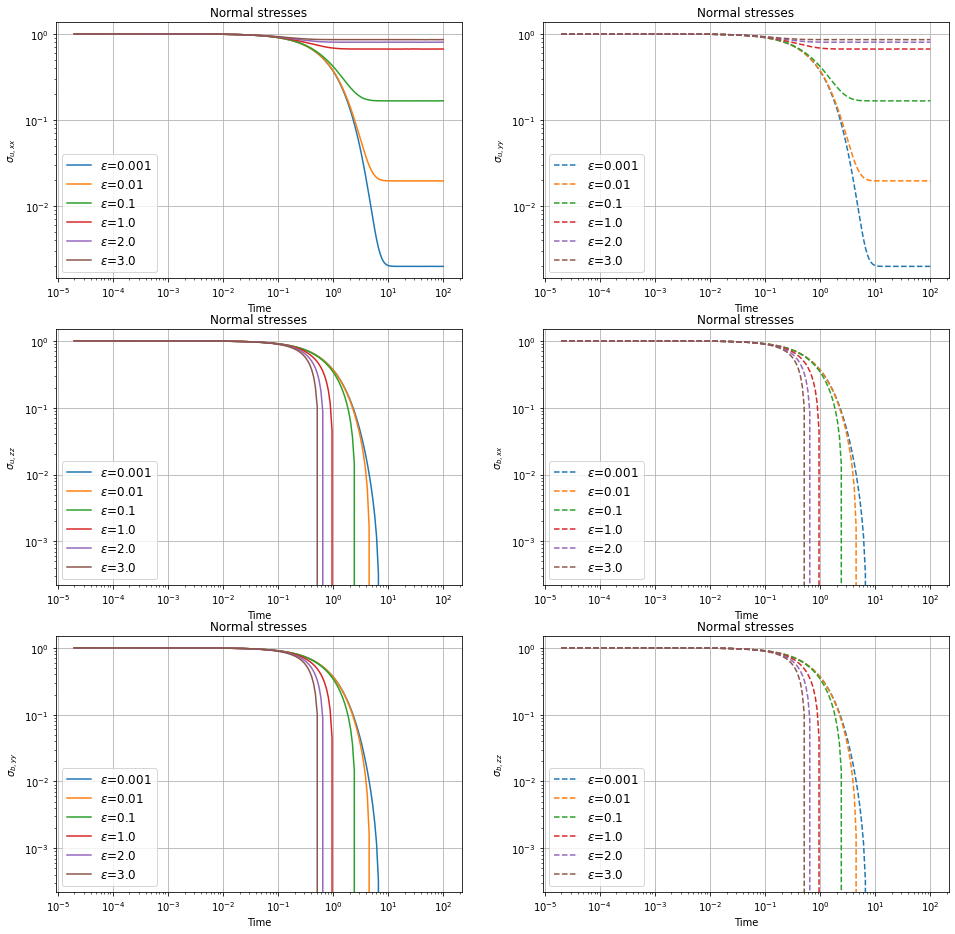

In [4]:
fig, axs = plt.subplots(3, 2, figsize=(16, 16))
axs = axs.flatten() #Making it a 1D array, in number order
for i in range(len(StrainRate)):
    sigma_u_sol = sigma_u_list[i]
    sigma_b_sol = sigma_b_list[i]
    axs[0].plot(t, sigma_u_sol[:, 0, 0], label=fr"$\epsilon$={StrainRate[i]}")
    axs[2].plot(t, sigma_u_sol[:, 1, 1], label=fr"$\epsilon$={StrainRate[i]}")
    axs[4].plot(t, sigma_u_sol[:, 2, 2], label=fr"$\epsilon$={StrainRate[i]}")
    axs[1].plot(t, sigma_b_sol[:, 0, 0], '--', label=fr"$\epsilon$={StrainRate[i]}")
    axs[3].plot(t, sigma_b_sol[:, 1, 1], '--', label=fr"$\epsilon$={StrainRate[i]}")
    axs[5].plot(t, sigma_b_sol[:, 2, 2], '--', label=fr"$\epsilon$={StrainRate[i]}")

#Making a list which holds the labels for the y-axis
y_axis_labels = [r"$\sigma_{u,xx}$", r"$\sigma_{u,yy}$", r"$\sigma_{u,zz}$",
                 r"$\sigma_{b,xx}$", r"$\sigma_{b,yy}$", r"$\sigma_{b,zz}$"]
for i in range(len(StrainRate)):
    axs[i].set_title("Normal stresses")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel(y_axis_labels[i])
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    axs[i].legend(fontsize=12)
    axs[i].grid(True)
    
fig.savefig("normal_stresses_simplified_inputs_graphs.png", dpi=300, bbox_inches="tight")

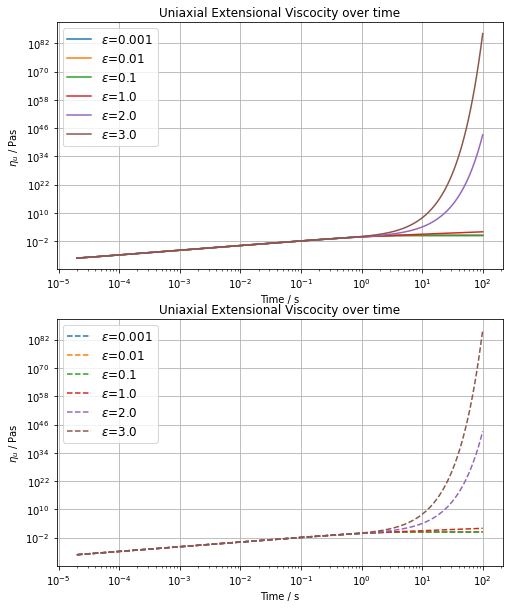

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10))
axs = axs.flatten() #Making it a 1D array, in number order
for i in range(len(StrainRate)):
    sigma_u_sol = sigma_u_list[i]
    sigma_b_sol = sigma_b_list[i]
    uniaxial_ext_visc_u = (sigma_u_sol[:, 0, 0] - sigma_u_sol[:, 1, 1])/StrainRate[i]
    uniaxial_ext_visc_b = (sigma_b_sol[:, 0, 0] - sigma_b_sol[:, 1, 1])/StrainRate[i]

    # --- New plot: Stress vs Strain ---
    axs[0].plot(t, uniaxial_ext_visc_u, label=fr"$\epsilon$={StrainRate[i]}")
    axs[1].plot(t, uniaxial_ext_visc_b, '--', label=fr"$\epsilon$={StrainRate[i]}")

for i in range(0,2):
    axs[i].set_xlabel("Time / s")
    axs[i].set_ylabel(r"$\eta_{u}$ / Pas")
    axs[i].set_title("Uniaxial Extensional Viscocity over time")
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    axs[i].legend(fontsize=12)
    axs[i].grid(True)
    
fig.savefig("extensional_viscocity_simplified_inputs_graphs.png", dpi=300, bbox_inches="tight")